# GPCR Analysis

In [1]:
import glob
import os
import subprocess

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Helvetica'] + plt.rcParams['font.sans-serif']

from IPython.display import display, HTML

%matplotlib inline

outdir = '../output/gpcr_analysis'
if not os.path.exists(outdir):
    os.makedirs(outdir)
private_outdir = '../private_output/gpcr_analysis'
if not os.path.exists(private_outdir):
    os.makedirs(private_outdir)

In [2]:
fn = '/srv/gsfs0/projects/rivas/data/gencode.v19_20170302/parsing/gencode.v19.annotation.table.tsv'
if not os.path.exists(fn):
    fn = '/oak/stanford/groups/mrivas/public_data/gencode.v19_20170526/parsing/gencode.v19.annotation.table.tsv'
gtable = pd.read_table(fn, index_col=0)
gtable['gencode_id'] = gtable.index
gtable.index = [x.split('.')[0] for x in gtable.index]

In [3]:
gpcr_genes = pd.read_table('../data/drug_target_gpcrs.txt')

In [4]:
array = pd.read_csv('/share/PI/mrivas/data/ukbb/array/Axiom_UKB_WCSG.na34.annot.csv.gz', 
                    skiprows=19)
array['position'] = (array['Chromosome'].astype(str) + ':' + 
                     array['Physical Position'].astype(str))
array_snps = array[array['dbSNP Loctype'].astype(str) == '2']

/share/PI/mrivas/anaconda/3.5/envs/lof-enrichment/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
fn = '../output/amr_allele_list/missense_lof.tsv'
vrs = pd.read_table(fn,
                    dtype={'CHROM':str, 'POS':int, 'REF':str, 'ALT':str, 'AC_AFR':int, 'AC_AMR':int, 
                           'AC_ASJ':int, 'AC_EAS':int, 'AC_FIN':int, 'AC_NFE':int, 'AC_OTH':int, 
                           'AC_SAS':int, 'AN_AFR':int, 'AN_AMR':int, 'AN_ASJ':int, 'AN_EAS':int, 
                           'AN_FIN':int, 'AN_NFE':int, 'AN_OTH':int, 'AN_SAS':int, 'Allele':str,
                           'Consequence':str, 'IMPACT':str, 'Gene':str, 'BIOTYPE':str, 'SIFT':str, 
                           'PolyPhen':str, 'CLIN_SIG':str, 'LoF':str, 'LoF_filter':str, 
                           'LoF_flags':str, 'LoF_info':str})

In [6]:
pops = [x.split('_')[1] for x in vrs.columns if 'AC_' in x]
for pop in pops:
    vrs['AF_{}'.format(pop)] = vrs['AC_{}'.format(pop)].astype(float) / vrs['AN_{}'.format(pop)]

In [7]:
# Maximum number of chromosomes genotyped per population.
pop_max = vrs[['AN_{}'.format(x) for x in pops]].max()
pop_max.index = [x.split('_')[1] for x in pop_max.index]

In [8]:
pops = [x.split('_')[1] for x in vrs.columns if 'AC_' in x]
for pop in pops:
    vrs['AF_{}'.format(pop)] = vrs['AC_{}'.format(pop)].astype(float) / vrs['AN_{}'.format(pop)]
    
for pop in pops:
    vrs['GP_{}'.format(pop)] = vrs['AN_{}'.format(pop)].astype(float) / pop_max[pop]

In [9]:
# Remove variants that aren't in GCPR genes.
s = set(gpcr_genes['HGNC symbol'])
s = gtable[gtable.gene_name.apply(lambda x: x in s)].index
vrs_f = vrs[vrs.Gene.apply(lambda x: x in s)]
# Remove variants that have no alternate alleles in NFE.
vrs_f = vrs_f[vrs_f['AC_NFE'] != 0]
# Remove sites that weren't called for at least 80% of haplotypes in all 
# populations. These sites may not be accurately genotyped.
cols = [x for x in vrs_f.columns if 'GP_' in x]
m = vrs_f[cols].min(axis=1)
vrs_f = vrs_f[m > 0.8]
vrs_f['position'] = vrs_f['CHROM'] + ':' + vrs_f['POS'].astype(str)
# Remove X chromosome variants.
vrs_f = vrs_f[vrs_f['CHROM'] != 'X']
# Split into missense and loss of function variants.
lof = vrs_f[vrs_f['LoF'] == 'HC']
missense = vrs_f[vrs_f['LoF'].isnull()]

In [10]:
a = vrs_f.shape[0]
b = lof.shape[0]
c = missense.shape[0]
print('{:,} total GCPR variants ({:,} LoF, {:,} missense) in gnomad'.format(
    a, b,c ))

38,936 total GCPR variants (2,657 LoF, 36,099 missense) in gnomad


In [11]:
shared = (set(vrs_f['position']) & set(array_snps['position']))
not_on_array = list(set(vrs_f['position']) - shared)
lof_shared = (set(lof['position']) & set(array_snps['position']))
gpcr_ukb = vrs_f[vrs_f['position'].apply(lambda x: x in shared)]
print('{:,} ({:,} LoF) GPCR variants on genotyping array.'.format(
    len(shared), len(lof_shared)))

1,129 (96 LoF) GPCR variants on genotyping array.


In [12]:
pd.cut(lof.AF_NFE, np.arange(0, 1.1, 0.1)).value_counts().sort_index()

(0, 0.1]      2655
(0.1, 0.2]       1
(0.2, 0.3]       1
(0.3, 0.4]       0
(0.4, 0.5]       0
(0.5, 0.6]       0
(0.6, 0.7]       0
(0.7, 0.8]       0
(0.8, 0.9]       0
(0.9, 1]         0
Name: AF_NFE, dtype: int64

In [13]:
pd.cut(missense.AF_NFE, np.arange(0, 1.1, 0.1)).value_counts().sort_index()

(0, 0.1]      35935
(0.1, 0.2]       47
(0.2, 0.3]       25
(0.3, 0.4]       16
(0.4, 0.5]       14
(0.5, 0.6]       15
(0.6, 0.7]       10
(0.7, 0.8]        8
(0.8, 0.9]        4
(0.9, 1]         25
Name: AF_NFE, dtype: int64

We can see that most of the variants are on the lower end of the frequency spectrum
as we'd expect.

In [14]:
to_drop = [x for x in gpcr_ukb.columns if ('AC_' in x) or ('AN_' in x) or 
          ('AF_' in x) or ('GP_' in x)]
to_drop = [x for x in to_drop if 'NFE' not in x]
gpcr_ukb = gpcr_ukb.drop(to_drop, axis=1)

In [15]:
gpcr_ukb.head()

,CHROM,POS,REF,ALT,AC_NFE,AN_NFE,Allele,Consequence,IMPACT,Gene,...,SIFT,PolyPhen,CLIN_SIG,LoF,LoF_filter,LoF_flags,LoF_info,AF_NFE,GP_NFE,position
8128,1,1267040,T,C,2,109110,C,missense_variant,MODERATE,ENSG00000169962,...,tolerated(0.1),probably_damaging(0.975),NaN,NaN,NaN,NaN,NaN,0.000018,0.976638,1:1267040
8129,1,1267040,T,G,24,109110,G,missense_variant,MODERATE,ENSG00000169962,...,deleterious(0.05),benign(0.284),NaN,NaN,NaN,NaN,NaN,0.000220,0.976638,1:1267040
8388,1,1268010,G,T,12,108814,T,missense_variant,MODERATE,ENSG00000169962,...,deleterious(0),probably_damaging(0.998),NaN,NaN,NaN,NaN,NaN,0.000110,0.973989,1:1268010
8474,1,1268388,G,A,88,110786,A,missense_variant,MODERATE,ENSG00000169962,...,tolerated(0.07),benign(0.284),NaN,NaN,NaN,NaN,NaN,0.000794,0.991640,1:1268388
8498,1,1268470,G,A,40,109082,A,missense_variant,MODERATE,ENSG00000169962,...,tolerated(0.21),benign(0.001),NaN,NaN,NaN,NaN,NaN,0.000367,0.976387,1:1268470


I'll calculate the minor allele frequency using the UKB data.

In [16]:
def maf(x):
    aa, ab, bb = map(int, x.split('/'))
    ac = ab + 2 * bb
    an = 2 * (aa + ab + bb)
    af = ac / float(an)
    if af > 0.5:
        af = 1 - af
    #return(ac, an, af)
    return(af)

In [17]:
hwe_fns = glob.glob('/share/PI/mrivas/data/ukbb/genorate/*hwe')
dfs = []
for fn in hwe_fns:
    dfs.append(pd.read_table(fn, sep=r"\s*"))
ukb_hwe = pd.concat(dfs).dropna()

/home/groups/mrivas/anaconda/3.5/envs/lof-enrichment/lib/python2.7/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [18]:
ukb_hwe['maf'] = ukb_hwe.GENO.apply(lambda x: maf(x))
ukb_hwe.index = ukb_hwe['SNP']
array_f = array.drop_duplicates(subset=['Affy SNP ID'])
array_f.index = array_f['Affy SNP ID']
shared_ids = set(array_f.ix[array_f.position.apply(lambda x: x in shared), 
                            'Affy SNP ID'])
ukb_hwe = ukb_hwe.ix[set(ukb_hwe.index) & shared_ids]
ukb_hwe['position'] = array_f.ix[ukb_hwe.index, 'position'].values


In [19]:
#sns.set_context('notebook', font_scale=1.5)
sns.set_palette(sns.color_palette('colorblind'))

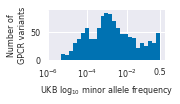

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.5))
se = ukb_hwe.maf
se = se[se != 0]
np.log10(se).hist(bins=25, ax=ax)
ax.set_ylabel('Number of\nGPCR variants', fontsize=8)
ax.set_xlabel('UKB $\log_{10}$ minor allele frequency', fontsize=8)
ax.set_xticks(np.log10(np.array([1e-6, 1e-4, 1e-2, 0.5])))
ax.set_xticklabels(['$10^{-6}$', '$10^{-4}$', '$10^{-2}$', '0.5'])
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'gpcr_sfs.pdf'))

In [21]:
pd.cut(np.log10(se), np.arange(-6, 1, 1)).value_counts().sort_index()

(-6, -5]     19
(-5, -4]    183
(-4, -3]    278
(-3, -2]    313
(-2, -1]    169
(-1, 0]     121
Name: maf, dtype: int64

In [22]:
pd.cut(np.log10(se), np.arange(-6, 1, 1)).value_counts().sort_index().cumsum()

(-6, -5]      19
(-5, -4]     202
(-4, -3]     480
(-3, -2]     793
(-2, -1]     962
(-1, 0]     1083
Name: maf, dtype: int64

In [23]:
(se < 0.01).value_counts()

True     793
False    290
Name: maf, dtype: int64

In [24]:
793. / se.shape[0]

0.7322253000923361

In [28]:
float((se > 0.000720).sum()) / se.shape[0]

0.6112650046168052

In [29]:
float((se > 0.000075).sum()) / se.shape[0]

0.8550323176361958

In [26]:
3 + 

SyntaxError: invalid syntax (<ipython-input-26-4715fb1d5390>, line 1)

## GPCR Variants in LD with Array Variants

Ths code in the next cell takes about an hour to run. 
TODO: I'll need to update the code below when I get the new all-pairs LD
files.

In [ ]:
ld = {}
for i,v in enumerate(not_on_array):
    chrom, pos = v.split(':')
    fn = ('/oak/stanford/groups/mrivas/public_data/1000genomes_20170416/'
          'ld_20170519/EUR/chrom{}_EUR.ld.gz'.format(chrom))
    res = subprocess.check_output('tabix {} {}:{}-{}'.format(fn, chrom, pos, pos),
                                  shell=True)
    if len(res) > 0:
        ld[v] = res

In [ ]:
def parse_ld_results(vals):
    lines = vals.strip().split('\n')
    lines = [x.split() for x in lines]
    columns = ['chrom1', 'pos1', 'name1', 'maf1', 'chrom2', 'pos2', 'name2', 'maf2', 'r2']
    tt = pd.DataFrame(lines, columns=columns)#, dtype=dtype)
    for i in ['pos1', 'pos2']:
        tt[i] = tt[i].astype(int)
    for i in ['maf1', 'maf2', 'r2']:
        tt[i] = tt[i].astype(float)
    tt['position1'] = tt['chrom1'] + ':' + tt['pos1'].astype(str)
    tt['position2'] = tt['chrom2'] + ':' + tt['pos2'].astype(str)
    return tt

In [ ]:
ld_parsed = {}
for k in ld.keys():
    ld_parsed[k] = parse_ld_results(ld[k])
    ld_parsed[k] = ld_parsed[k][ld_parsed[k]['r2'] > 0.8]

In [ ]:
s = set(array_snps.position)
in_ld = []
in_ld_parsed = {}
in_ld_max = []
for k in ld_parsed.keys():
    overlap = set(ld_parsed[k]['position2']) & s
    if len(overlap) > 0:
        in_ld.append(k)
        in_ld_parsed[k] = ld_parsed[k][ld_parsed[k]['position2'].apply(lambda x: x in s)]
        in_ld_max.append(in_ld_parsed[k]['r2'].max())
print('{:,} additional variants in high LD (> 0.8) with array SNPs.'.format(
    len(in_ld)))

In [ ]:
in_ld_max